<a href="https://colab.research.google.com/github/KyraSebestyen/bioEmbedding/blob/main/mapBertToTokens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# connect to google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!pip install flair

     |████████████████████████████████| 322 kB 11.9 MB/s 
     |████████████████████████████████| 64 kB 2.8 MB/s 
     |████████████████████████████████| 788 kB 49.1 MB/s 
     |████████████████████████████████| 1.2 MB 46.5 MB/s 
     |████████████████████████████████| 19.7 MB 39.0 MB/s 
     |████████████████████████████████| 61 kB 569 kB/s 
     |████████████████████████████████| 3.4 MB 44.3 MB/s 
     |████████████████████████████████| 48 kB 5.7 MB/s 
     |████████████████████████████████| 981 kB 18.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 895 kB 37.7 MB/s 
     |████████████████████████████████| 596 kB 48.8 MB/s 
     |████████████████████████████████| 3.3 MB 43.9 MB/s 
  Created wheel for gdown: filename=gdown-3.12.2-py3-none-any.whl size=9704 sha256=28dd5657e46ebc77c8ed4157ea87eab9fceecf1c82f6

In [ ]:
import pandas
import numpy
from tqdm.notebook import tqdm
import os
import gzip
import json
import seaborn
import matplotlib.pyplot
import flair
from flair.data import Sentence
from flair.embeddings import TransformerWordEmbeddings
import torch
import spacy

In [ ]:
lossData = []

with open('/content/gdrive/My Drive/finetune_neu/checkpoint-17000/trainer_state.json') as file:
  checkpointData = json.load(file)
checkpointData = pandas.DataFrame(checkpointData["log_history"])
lossData.append(checkpointData)

lossData = pandas.concat(lossData)

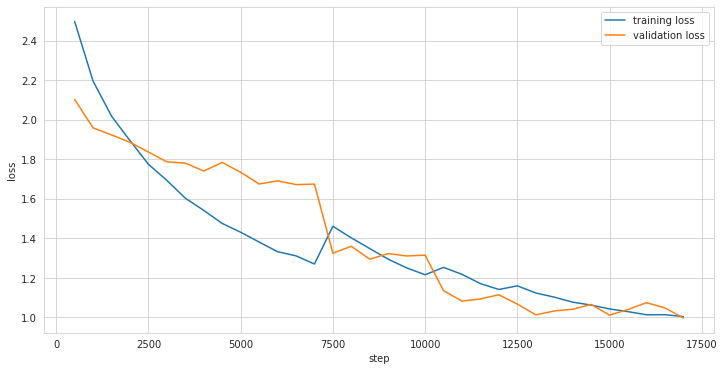

In [ ]:
matplotlib.pyplot.figure(figsize = (12, 6))
seaborn.set_style("whitegrid")

seaborn.lineplot(x = "step", y = "loss", data = lossData, label = "training loss")
seaborn.lineplot(x = "step", y = "eval_loss", data = lossData, label = "validation loss")

In [ ]:
selectedBert = "/content/gdrive/My Drive/finetune_neu/checkpoint-17000"

In [ ]:
corpus = pandas.read_csv('/content/gdrive/My Drive/Colab_Notebooks/Okkurrenzen Auszug.csv', sep = ';', quoting = 3) # 3 means QUOTE_NONE

In [ ]:
with pandas.option_context('display.max_rows', 100, 'display.max_columns', 10):
  display(corpus)

,OccId,Term,Scientific Name,File,1000-Words-Frame,text
0,cattle,Bos taurus,organism,PG10005,1,"the travellers visit a gentleman farmer, who i..."
1,plant,Plantae,organism,PG10005,2,i then exhibited some of what i considered my ...
2,bird,Aves,organism,PG10005,2,"i next produced some rare insects, and feather..."
3,insect,Insecta,organism,PG10005,2,"i next produced some rare insects, and feather..."
4,shark,Selachimorpha,organism,PG10005,4,"we had, in singular succession, dead calms and..."
...,...,...,...,...,...,...
20671,tree,Tracheophyta,organism,PG1015,154,"at length, for the first time during about hal..."
20672,horse,Equus ferus caballus,organism,PG1015,154,"westport had beheld strange scenes, but a roug..."
20673,horse,Equus ferus caballus,organism,PG1015,155,here we were soon visited by a number of peopl...
20674,moccasin,Agkistrodon,organism,PG1015,155,in the morning we hardly recognized each other...


In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
nlp.disable_pipes(["parser", "ner"])
# nlp.add_pipe(nlp.create_pipe("sentencizer") , after = "tagger") # not needed because corpus is provided sentence wise

[('parser', <spacy.pipeline.pipes.DependencyParser at 0x7f331dee4670>),
 ('ner', <spacy.pipeline.pipes.EntityRecognizer at 0x7f331dee4750>)]

In [ ]:
# dürfen Sätze mehrfach vorkommen? Oder verzerrt sich dadurch die Embedding Berechnung?

In [ ]:
def spacy_to_json(spacy_doc):
    doc_dict = spacy_doc.to_json()
    # print(doc_dict)
    sent_boundaries = [10000] # habe nur Sätze und brauche deshalb nicht Satzende
    doc_dict = doc_dict["tokens"]
    current_sentence = 0
    for i, t in enumerate(spacy_doc):
        doc_dict[i]["text"] = t.text
        if spacy_doc[i].is_sent_start:
            doc_dict[i]["is_sent_start"] = True
        else:
            doc_dict[i]["is_sent_start"] = False
        if doc_dict[i]["end"] > sent_boundaries[current_sentence]:
            current_sentence += 1
        doc_dict[i]["sentence_id"] = current_sentence
    return doc_dict


In [ ]:
def get_batches(lst, batch_size):
  for i in range(0, len(lst), batch_size): 
    yield lst[i : i + batch_size] # gibt stückweise Elemente der Liste (1 Batch pro Iteration)

In [ ]:
def get_sentences(doc):
  current_sentence = 0
  sentence = []
  for t in doc:
    if t["sentence_id"] == current_sentence:
      sentence.append(t["text"])
    else:
      yield sentence 
      sentence = [t["text"]]
      current_sentence = t["sentence_id"]
    if len(sentence) > 0:
      yield sentence

In [ ]:
def get_sentence_token_mapping(doc):
  sentence_token_mapping = {}

  current_sentence = 0
  token_id_in_sent = 0
  for i, t in enumerate(doc):
    if t["sentence_id"] != current_sentence:
      current_sentence = t["sentence_id"]
      token_id_in_sent = 0
    sentence_token_mapping[(current_sentence, token_id_in_sent)] = i
    token_id_in_sent += 1

  return sentence_token_mapping

In [ ]:
bert_model = TransformerWordEmbeddings(selectedBert,
                                       subtoken_pooling = "mean",
                                       layers = "all",
                                       layer_mean = True,
                                       allow_long_sentences = True)

out_filename_embeddings = "embedding/embeddings.npy"
#out_file_metadata = gzip.open("embeddings/token_metadata.tsv.gz", "wt")

metadata_columns = ["token_id", "token", "lemma", "doc_token_id", "sentence_id", "text_position"]

#out_file_metadata.write("\t".join(metadata_columns) + "\n")

embeddings = []

running_token_id = 0
for batch_indices in get_batches(corpus.index.to_list(), 50): # holt sich Indizes des Batch
    metadata = []
    
    for (occId, file), doc in tqdm(zip(corpus.loc[batch_indices, ["OccId", "File"]].values, # sucht die Zeilen batch_indices und die Spalten OccId und File
                                                   nlp.pipe(corpus.loc[batch_indices, "text"].values, # sucht die Spalte text und wendet die Pipeline auf jeden Satz an
                                                   batch_size = 10))): # zip macht aus zwei Arrays ein Array von Tupeln
        doc = spacy_to_json(doc)
        
        sentences = []


        for s in get_sentences(doc):
            sentences.append(Sentence(s)) 

        sent_tokens_map = get_sentence_token_mapping(doc)

        #print(sent_tokens_map)

        bert_model.embed(sentences)
        
    
        #sentences.append(Sentence(doc))
            
        #sent_tokens_map = get_sentence_token_mapping(doc)
        
        #bert_model.embed(sentences)

        


0it [00:00, ?it/s]

0it [00:00, ?it/s]

RuntimeError: ignored